### 초기 셋팅

In [ ]:
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
"""
DeepSNAP는 그래프 신경망(Graph Neural Networks)을 구축하고 훈련하기 위한 파이썬 패키지
DeepSNAP은 PyTorch 기반의 그래프 신경망 라이브러리 PyG(PyTorch Geometric)에서 영감을 받아 개발되었다. DeepSNAP은 PyG와 유사한 인터페이스를 제공하여 그래프 데이터를 로드하고 전처리할 수 있다.
"""
!pip install -U -q PyDrive
!pip install torch_scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

# Install required packages.
# !pip install torch-sparse
print(torch.__version__)
print(torch.version.cuda)

import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch import nn, optim, Tensor
from torch_sparse import SparseTensor, matmul
from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj
#-- import required modules Blog

# download the dataset
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

rating_path = '/content/ml-latest-small/ratings.csv'
item_path = "/content/ml-latest-small/movies.csv"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 25.3 MB/s eta 0:00:00
cpu
False
2.1.0+cu118
11.8


Extracting ./ml-latest-small.zip


In [ ]:
remove_size = 30
# def MF_data(path, data_frame, rating_threshold = 5, excluded_user =None):

def blog_LightGCN_data(path, data_frame, rating_threshold =5, excluded_user=None):

  #-- 유저, 아이템 매핑
  rating_data = pd.read_csv(path[0], index_col= data_frame[0])
  item_data = pd.read_csv(path[1], index_col= data_frame[1])
  data = pd.read_csv(path[0])


  #-- 테스트를 위한 특정 유저의 가장 앞에 있는 데이터 삭제

  if excluded_user is not None:
    print("{}번째 유저 {}이상 데이터 삭제하기 전".format(excluded_user, rating_threshold))
    excluded_user_data = data[data[data_frame[0]] == excluded_user]
    print(excluded_user_data.head(10))

    user_data = data[data[data_frame[0]] == excluded_user]
    user_data_5stars = user_data[user_data[data_frame[2]] >= rating_threshold]  # Filter the data with a rating of 5.0r_user_data[r_user_data[data_frame[2]] == 5.0]  # Filter the data with a rating of 5.0

    r_user_data =  rating_data[rating_data.index == excluded_user].reset_index()

    if not user_data_5stars.empty:
      excluded_number = remove_size
      user_data_5stars = user_data_5stars.head(excluded_number)
      r_user_data_5stars = r_user_data[r_user_data[data_frame[2]] >= rating_threshold]
      data = data.drop(user_data_5stars.index)

      row_index = []
      for i in range(0,excluded_number):
        row_index.append(r_user_data_5stars.iloc[i].name)

      rating_data = rating_data.reset_index().drop(row_index[0])
      rating_data.set_index(data_frame[0], inplace=True)
      for i in range(1, len(row_index)) :
        rating_data = rating_data.reset_index().drop(row_index[i]-i)
      # rating_data = rating_data.drop(rating_data.iloc.nam)
        rating_data.set_index(data_frame[0], inplace=True)

    excluded_user_data = data[data[data_frame[0]] == excluded_user]
    print("\n\n\n{}번째 유저 {} 이상 데이터 삭제하기 후".format(excluded_user, rating_threshold))
    print(excluded_user_data.head(10))

  # # rating_data의 컬럼 확인
  # print(rating_data.head(5))

  user_mapping = {index: i for i, index in enumerate(rating_data.index.unique())}
  item_mapping = {index: i for i, index in enumerate(item_data.index.unique())}

  #-- 매핑 데이터로 edge연결
  edge_index = None
  src = [user_mapping[index] for index in data[data_frame[0]]]
  dst = [item_mapping[index] for index in data[data_frame[1]]]
  edge_attr = torch.from_numpy(data[data_frame[2]].values).view(-1, 1).to(torch.long) >= 3.5

  edge_index = [[], []]
  for i in range(edge_attr.shape[0]):
    if edge_attr[i]:
        edge_index[0].append(src[i])
        edge_index[1].append(dst[i])
  edge_index = torch.tensor(edge_index)

  #-- 데이터 분할 8:1:1
  num_users, num_movies = len(user_mapping), len(item_mapping)
  num_interactions = edge_index.shape[1]
  all_indices = [i for i in range(num_interactions)]

  train_indices, test_indices = train_test_split(
      all_indices, test_size=0.2, random_state=1)
  val_indices, test_indices = train_test_split(
      test_indices, test_size=0.5, random_state=1)

  train_edge_index = edge_index[:, train_indices]
  val_edge_index = edge_index[:, val_indices]
  test_edge_index = edge_index[:, test_indices]

  print("Train Edge Data : ", train_edge_index.shape)
  print("Val Edge Data :", val_edge_index.shape)
  print("Test Edge Data : ", test_edge_index.shape)

  #-- 연결된 엣지를 희소행렬로 변환
  # convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
  from torch_geometric.utils import train_test_split_edges

  train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
      num_users + num_movies, num_users + num_movies))
  val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
      num_users + num_movies, num_users + num_movies))
  test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
      num_users + num_movies, num_users + num_movies))

  tet_edge_data = [edge_index, train_edge_index, val_edge_index, test_edge_index]
  tet_sparse_data = [train_sparse_edge_index, val_sparse_edge_index, test_sparse_edge_index]
  return tet_edge_data, tet_sparse_data, user_mapping, item_mapping
#-- Blog --

In [ ]:
excluded_user_id = 50
data_frame = ["userId", "movieId", "rating"]
path = [rating_path, item_path]
rating_threshold = 4

blog_tet_edge_data, blog_tet_sparse_data, user_mapping, item_mapping = blog_LightGCN_data(path, data_frame, rating_threshold, excluded_user_id)

50번째 유저 4이상 데이터 삭제하기 전
      userId  movieId  rating   timestamp
7112      50        1     3.0  1514238116
7113      50       32     3.0  1523740563
7114      50      111     4.0  1534178790
7115      50      165     3.0  1514238058
7116      50      296     4.0  1500573696
7117      50      318     3.5  1514237959
7118      50      356     3.0  1514238146
7119      50      541     4.0  1514238015
7120      50      593     3.5  1514237974
7121      50      596     2.0  1514238575



50번째 유저 4 이상 데이터 삭제하기 후
      userId  movieId  rating   timestamp
7112      50        1     3.0  1514238116
7113      50       32     3.0  1523740563
7115      50      165     3.0  1514238058
7117      50      318     3.5  1514237959
7118      50      356     3.0  1514238146
7120      50      593     3.5  1514237974
7121      50      596     2.0  1514238575
7123      50      741     3.5  1515105957
7125      50      783     2.5  1514238681
7126      50      837     2.5  1514239044
Train Edge Data :  torch.S

### MF모델 정의

#### 테스트용

In [ ]:
num_users = blog_tet_edge_data[0][0].max().item()+1
num_items = blog_tet_edge_data[0][1].max().item()+1
embedding_dim = 32

user_indices = blog_tet_edge_data[1][0]
item_indices = blog_tet_edge_data[1][1]

mf_user_embeddings = nn.Embedding(num_users, embedding_dim)
mf_item_embeddings = nn.Embedding(num_items, embedding_dim)


nn.init.normal_(mf_user_embeddings.weight, std=0.1)
nn.init.normal_(mf_item_embeddings.weight, std=0.1)

print(mf_user_embeddings)
print(mf_item_embeddings)

print("user_indices size is ",user_indices.size()) #-- 38840 -> 유저-아이템 상호작용 횟수
print("item_indices size is ",item_indices.size()) #-- 38840 -> 유저-아이템 상호작용 횟수

#-- 처음 eu 임베딩값은 (610, 32)
#-- 처음 ei 임베딩값은 (9742, 32)
mf_user_embedding = mf_user_embeddings(user_indices)
mf_item_embedding = mf_item_embeddings(item_indices)
#-- 유저-아이템 상호작용 기반으로 유저 임베딩 아이템 임베딩

print("user_embedding size is {}".format(mf_user_embedding.size())) #-- [38840, 32]
print("item_embedding size is {}".format(mf_item_embedding.size())) #-- [38840, 32]


predictions = (mf_user_embedding * mf_item_embedding).sum(1) #-- 38840 1차원으로
print("predictions size is ",predictions.size())

Embedding(610, 32)
Embedding(9742, 32)
user_indices size is  torch.Size([38840])
item_indices size is  torch.Size([38840])
user_embedding size is torch.Size([38840, 32])
item_embedding size is torch.Size([38840, 32])
predictions size is  torch.Size([38840])


#### MFGCN

In [ ]:
class MFGCN(MessagePassing):
      def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
          super().__init__()
          self.num_users, self.num_items = num_users, num_items
          self.embedding_dim, self.K = embedding_dim, K
          self.add_self_loops = add_self_loops
          self.users_emb = nn.Embedding(
              num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
          self.items_emb = nn.Embedding(
              num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
          nn.init.normal_(self.users_emb.weight, std=0.1)
          nn.init.normal_(self.items_emb.weight, std=0.1)


          self.mf_user_embedding = self.users_emb
          self.mf_item_embedding = self.items_emb
      def forward(self, edge_index: SparseTensor):
          # compute \tilde{A}: symmetrically normalized adjacency matrix
          edge_index_norm = gcn_norm(
              edge_index, add_self_loops=self.add_self_loops)

          # print(self.users_emb) #-- Embedding(610, 32)
          # print(self.items_emb) #-- Embedding(9742, 32)

          #-- MF 기법 --#
          # mf_user_embedding = self.users_emb
          # mf_item_embedding = self.items_emb
          # print("mf_user", mf_user_embedding)
          # print("mf_item_embedding", mf_item_embedding)
          row, col, _ = edge_index_norm.coo()
          user_indices = row
          item_indices = col
          # print("user_indices size is ",user_indices.size()) #-- 38840 -> 유저-아이템 상호작용 횟수
          # print("item_indices size is ",item_indices.size()) #-- 38840 -> 유저-아이템 상호작용 횟수
          mf_user_embedding = self.users_emb(user_indices)
          mf_item_embedding = self.items_emb(item_indices)

          user_avg_emb = torch.zeros(self.num_users, self.embedding_dim).to(self.users_emb.weight.device)
          item_avg_emb = torch.zeros(self.num_items, self.embedding_dim).to(self.items_emb.weight.device)

          user_counts = torch.bincount(user_indices, minlength=self.num_users).float().clamp(min=1) # 최소 1로 설정하여 0으로 나누는 것을 방지
          item_counts = torch.bincount(item_indices, minlength=self.num_items).float().clamp(min=1)

          user_avg_emb.index_add_(0, user_indices, mf_user_embedding)
          item_avg_emb.index_add_(0, item_indices, mf_item_embedding)

          user_avg_emb /= user_counts.unsqueeze(-1)
          item_avg_emb /= item_counts.unsqueeze(-1)

          # predictions = (mf_user_embedding * mf_item_embedding).sum(1)
          # --predictions size is  torch.Size([38840])
          # print(predictions.size())

          # print("user_embedding size is {}".format(mf_user_embedding.size())) #-- [38840, 32]
          # print("item_embedding size is {}".format(mf_item_embedding.size())) #-- [38840, 32]
          #-- MF 기법 --#

          #== LightGCN ==#
          emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
          embs = [emb_0]
          emb_k = emb_0
          # print("emb_0", emb_0.size()) #-- 610 + 9742 => [10352, 32]

          # multi-scale diffusion
          for i in range(self.K):
              emb_k = self.propagate(edge_index_norm, x=emb_k)
              # print("emb_k", emb_k.size()) #-- 610 + 9742 => [10352, 32]
              embs.append(emb_k)
          embs = torch.stack(embs, dim=1)

          # print("embs", embs.size()) #-- [10352, 4, 32] k만큼 추가

          emb_final = torch.mean(embs, dim=1) # E^K 10352, 32
          # print("emb_final is ", emb_final.size())

          users_emb_final, items_emb_final = torch.split(
              emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K
          # returns e_u^K, e_u^0, e_i^K, e_i^0
          # print("users_emb_final is ", users_emb_final.size())
          # print("items_emb_final is ", items_emb_final.size())
          #== LightGCN ==#


          # combined_users_emb = mf_user_embedding[user_indices] + users_emb_final[user_indices]
          # combined_items_emb = mf_item_embedding[item_indices] + items_emb_final[item_indices]
          combined_users_emb = user_avg_emb + users_emb_final
          combined_items_emb = item_avg_emb + items_emb_final
          # print("combined_users_emb",combined_users_emb.size())
          # print("combined_items_emb",combined_items_emb.size())

          # 결합된 임베딩 정규화 (옵션)
          # combined_users_emb /= 2.0
          # combined_items_emb /= 2.0
          # e_u^K, e_u^0, e_i^K, e_i^0 형태로 임베딩 반환
          return combined_users_emb, self.users_emb.weight, combined_items_emb, self.items_emb.weight

          # return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

      def message(self, x_j: Tensor) -> Tensor:
          return x_j

      def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
          # computes \tilde{A} @ x
          return matmul(adj_t, x)

In [ ]:
blog_model = MFGCN(len(user_mapping), len(item_mapping), embedding_dim= 32)
# model = model.to(device)
# model.train()
# LR = 1e-4
# optimizer = optim.Adam(model.parameters(), lr=LR)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# edge_index = blog_tet_edge_data[0].to(device)
# train_edge_index = blog_tet_edge_data[1].to(device)
# train_sparse_edge_index = blog_tet_sparse_data[0].to(device)


# val_edge_index = blog_tet_edge_data[2].to(device)
# val_sparse_edge_index = blog_tet_sparse_data[1].to(device)

# users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
#           train_sparse_edge_index)


### 모델 학습

In [ ]:
#-- 손실함수 bpr
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss
    return loss
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

# helper function to get N_u
def get_user_positive_items(edge_index):
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg
def blog_fit(model, blog_tet_edge_data, blog_tet_sparse_data, epochs = 50):
  # define contants
  ITERATIONS = epochs
  BATCH_SIZE = 2048
  LR = 1e-3
  ITERS_PER_EVAL = 300
  ITERS_PER_LR_DECAY = 300
  K = 10
  LAMBDA = 1e-6

  model = model.to(device)
  model.train()

  optimizer = optim.Adam(model.parameters(), lr=LR)
  scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

  edge_index = blog_tet_edge_data[0].to(device)
  train_edge_index = blog_tet_edge_data[1].to(device)
  train_sparse_edge_index = blog_tet_sparse_data[0].to(device)

  val_edge_index = blog_tet_edge_data[2].to(device)
  val_sparse_edge_index = blog_tet_sparse_data[1].to(device)

  # training loop
  train_losses = []
  val_losses = []

  for iter in range(ITERATIONS):
      # forward propagation
      users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
          train_sparse_edge_index)

      # mini batching
      user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(
          BATCH_SIZE, train_edge_index)
      user_indices, pos_item_indices, neg_item_indices = user_indices.to(
          device), pos_item_indices.to(device), neg_item_indices.to(device)
      users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
      pos_items_emb_final, pos_items_emb_0 = items_emb_final[
          pos_item_indices], items_emb_0[pos_item_indices]
      neg_items_emb_final, neg_items_emb_0 = items_emb_final[
          neg_item_indices], items_emb_0[neg_item_indices]

      # loss computation
      train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                            pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

      if iter % ITERS_PER_EVAL == 0:
          model.eval()
          val_loss, recall, precision, ndcg = evaluation(
              model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
          print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
          train_losses.append(train_loss.item())
          val_losses.append(val_loss)
          model.train()

      if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
          scheduler.step()
  iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
  plt.plot(iters, train_losses, label='train')
  plt.plot(iters, val_losses, label='validation')
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.title('training and validation loss curves')
  plt.legend()
  plt.show()

### 학습 확인

[Iteration 0/20000] train_loss: -1.46415, val_loss: -1.24316, val_recall@10: 0.07699, val_precision@10: 0.04973, val_ndcg@10: 0.0715
[Iteration 300/20000] train_loss: -7.9834, val_loss: -6.69342, val_recall@10: 0.08248, val_precision@10: 0.05385, val_ndcg@10: 0.07929
[Iteration 600/20000] train_loss: -25.82973, val_loss: -21.76326, val_recall@10: 0.07912, val_precision@10: 0.05331, val_ndcg@10: 0.08168
[Iteration 900/20000] train_loss: -54.5865, val_loss: -45.71547, val_recall@10: 0.07907, val_precision@10: 0.05385, val_ndcg@10: 0.08233
[Iteration 1200/20000] train_loss: -88.74312, val_loss: -75.34441, val_recall@10: 0.08085, val_precision@10: 0.0542, val_ndcg@10: 0.08393
[Iteration 1500/20000] train_loss: -130.06308, val_loss: -109.89406, val_recall@10: 0.08043, val_precision@10: 0.05492, val_ndcg@10: 0.08426
[Iteration 1800/20000] train_loss: -174.10085, val_loss: -147.38057, val_recall@10: 0.0803, val_precision@10: 0.0551, val_ndcg@10: 0.08478
[Iteration 2100/20000] train_loss: -220

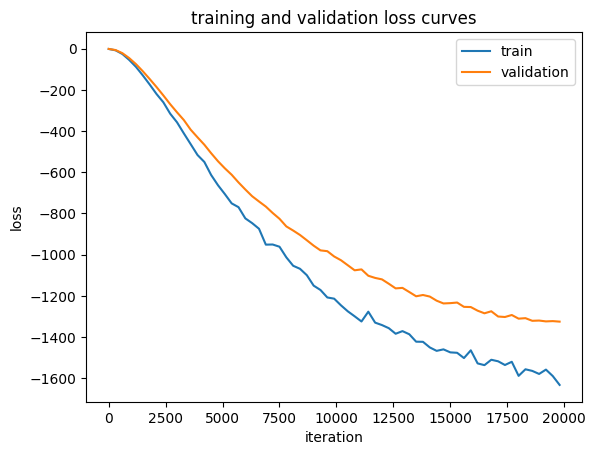

In [ ]:
blog_fit(blog_model, blog_tet_edge_data, blog_tet_sparse_data, epochs =20000)

In [ ]:
def blog_predict(model, user_id ,TopK, path, user_mapping, item_mapping, edge_index):

  df = pd.read_csv(path[1])
  movieid_title = pd.Series(df.title.values,index=df.movieId).to_dict()
  movieid_genres = pd.Series(df.genres.values,index=df.movieId).to_dict()

  user_pos_items = get_user_positive_items(edge_index)
  user = user_mapping[user_id]
  e_u = model.users_emb.weight[user]
  scores = model.items_emb.weight @ e_u

  values, indices = torch.topk(scores, k=len(user_pos_items[user]) + TopK)

  movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:TopK]
  movie_ids = [list(item_mapping.keys())[list(item_mapping.values()).index(movie)] for movie in movies]
  titles = [movieid_title[id] for id in movie_ids]
  genres = [movieid_genres[id] for id in movie_ids]

  # print(f"Here are some movies that user {user_id} rated highly")
  # for i in range(TopK):
  #     print(f"title: {titles[i]}, genres: {genres[i]} ")

  movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:TopK]
  movie_ids = [list(item_mapping.keys())[list(item_mapping.values()).index(movie)] for movie in movies]
  titles = [movieid_title[id] for id in movie_ids]
  genres = [movieid_genres[id] for id in movie_ids]

  # print(f"Here are some suggested movies for user {user_id}")
  return titles, genres

In [ ]:
user_id = 1
excluded_user = user_id
K = 10
rating_threshold = 4

In [ ]:
blog_titles_32_5000, blog_genres_32_5000 = blog_predict(blog_model, user_id , K, path, user_mapping, item_mapping, blog_tet_edge_data[0])

In [ ]:
#-- 내가 삭제한 데이터
data = pd.read_csv(path[0])
user_data = data[data[data_frame[0]] == excluded_user]
user_data_5stars = user_data[user_data[data_frame[2]] >= rating_threshold]  # Filter the data with a rating of 5.0r_user_data[r_user_data[data_frame[2]] == 5.0]  # Filter the data with a rating of 5.0
# print(user_data_5stars.head(10))
data = user_data_5stars.head(30)
moviedIds = data['movieId'].values

df = pd.read_csv(path[1])

titles = []
genres = []
for i in moviedIds:
    title = df[df['movieId'] == i]['title']
    genre = df[df['movieId'] == i]['genres']
    titles.append(title)
    genres.append(genre)
for i in range(len(moviedIds)):
  print(f"title: {titles[i].values}, genres: {genres[i].values} ")

title: ['Toy Story (1995)'], genres: ['Adventure|Animation|Children|Comedy|Fantasy'] 
title: ['Grumpier Old Men (1995)'], genres: ['Comedy|Romance'] 
title: ['Heat (1995)'], genres: ['Action|Crime|Thriller'] 
title: ['Seven (a.k.a. Se7en) (1995)'], genres: ['Mystery|Thriller'] 
title: ['Usual Suspects, The (1995)'], genres: ['Crime|Mystery|Thriller'] 
title: ['Bottle Rocket (1996)'], genres: ['Adventure|Comedy|Crime|Romance'] 
title: ['Braveheart (1995)'], genres: ['Action|Drama|War'] 
title: ['Rob Roy (1995)'], genres: ['Action|Drama|Romance|War'] 
title: ['Canadian Bacon (1995)'], genres: ['Comedy|War'] 
title: ['Desperado (1995)'], genres: ['Action|Romance|Western'] 
title: ['Billy Madison (1995)'], genres: ['Comedy'] 
title: ['Dumb & Dumber (Dumb and Dumber) (1994)'], genres: ['Adventure|Comedy'] 
title: ['Ed Wood (1994)'], genres: ['Comedy|Drama'] 
title: ['Star Wars: Episode IV - A New Hope (1977)'], genres: ['Action|Adventure|Sci-Fi'] 
title: ['Tommy Boy (1995)'], genres: ['Come

In [ ]:
#-- BLOG LightGCN
for i in range(K):
    # if any((blog_titles_32_5000[i] == title.values).all() for title in titles):
        print(blog_titles_32_5000[i])
print("==========================임베딩 사이즈 : 32, 에포크 : 5000 =============================")

Shawshank Redemption, The (1994)
Pulp Fiction (1994)
Godfather, The (1972)
Terminator 2: Judgment Day (1991)
Apollo 13 (1995)
Lord of the Rings: The Return of the King, The (2003)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Lord of the Rings: The Two Towers, The (2002)
Lion King, The (1994)
Memento (2000)
==========================임베딩 사이즈 : 32, 에포크 : 5000 =============================


LightGCN

In [ ]:
num_users = blog_tet_edge_data[0][0].max().item()+1
num_items = blog_tet_edge_data[0][1].max().item()+1
edge_index = blog_tet_edge_data[0] #-- edge_index 정보가 들어있음

embedding_dim = 32

user_indices = blog_tet_edge_data[1][0]
item_indices = blog_tet_edge_data[1][1]

K = 3
add_self_loops = False

gcn_user_embeddings = nn.Embedding(num_users, embedding_dim)
gcn_item_embeddings = nn.Embedding(num_items, embedding_dim)

nn.init.normal_(gcn_user_embeddings.weight, std=0.1)
nn.init.normal_(gcn_item_embeddings.weight, std=0.1)

print(gcn_user_embeddings) #-- Embedding(610, 32)
print(gcn_item_embeddings) #-- Embedding(9742, 32)

edge_index_norm = gcn_norm(
              edge_index, add_self_loops=False)

# print(edge_index) #-- 전체 인덱스 정보
# print(edge_index_norm[1]) #-- [0]번 인덱스 == edge_index [1]번 인덱스 == 정규화된 텐서값

emb_0 = torch.cat([gcn_user_embeddings.weight, gcn_item_embeddings.weight]) # E^0
#-- 유저와 아이템 임베딩을 합친 차원 [10352, 32]
print("emb_0", emb_0.size()) #-- 610 + 9742 => [10352, 32]
embs = [emb_0]
emb_k = emb_0



Embedding(610, 32)
Embedding(9742, 32)
emb_0 torch.Size([10352, 32])


NameError: ignored

In [ ]:
class Blog_LightGCN(MessagePassing):
      def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
          super().__init__()
          self.num_users, self.num_items = num_users, num_items
          self.embedding_dim, self.K = embedding_dim, K
          self.add_self_loops = add_self_loops
          self.users_emb = nn.Embedding(
              num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
          self.items_emb = nn.Embedding(
              num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0
          nn.init.normal_(self.users_emb.weight, std=0.1)
          nn.init.normal_(self.items_emb.weight, std=0.1)
      def forward(self, edge_index: SparseTensor):
          # compute \tilde{A}: symmetrically normalized adjacency matrix
          edge_index_norm = gcn_norm(
              edge_index, add_self_loops=self.add_self_loops)
          emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
          embs = [emb_0]
          emb_k = emb_0

          # multi-scale diffusion
          for i in range(self.K):
              emb_k = self.propagate(edge_index_norm, x=emb_k)
              embs.append(emb_k)
          embs = torch.stack(embs, dim=1)
          emb_final = torch.mean(embs, dim=1) # E^K
          users_emb_final, items_emb_final = torch.split(
              emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K
          # returns e_u^K, e_u^0, e_i^K, e_i^0
          return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

      def message(self, x_j: Tensor) -> Tensor:
          return x_j

      def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
          # computes \tilde{A} @ x
          return matmul(adj_t, x)

In [ ]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(MatrixFactorization, self).__init__()

        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # 임베딩 초기화
        self.mf_user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.mf_item_embeddings = nn.Embedding(num_items, embedding_dim)


    def forward(self, user_indices, item_indices):
        user_embedding = self.user_embedding(user_indices)
        item_embedding = self.item_embedding(item_indices)

        # 내적 연산으로 평점 예측
        predictions = (user_embedding * item_embedding).sum(1)
        return predictions

In [ ]:
# 하이퍼 파라미터
embedding_dim = 32
learning_rate = 0.001
num_epochs = 50

num_users = blog_tet_edge_data[0][0].max().item()+1
num_items = blog_tet_edge_data[0][1].max().item()+1
# blog_tet_edge_data, blog_tet_sparse_data, user_mapping, item_mapping
# print(blog_tet_edge_data[0][0])
# print(blog_tet_edge_data[0][0].max().item())

# print(blog_tet_edge_data[0][1])
# print(blog_tet_edge_data[0][1].max().item())

# 모델 초기화
model = MatrixFactorization(num_users, num_items, embedding_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
print(blog_tet_edge_data[1][0]) #-- train
print(blog_tet_edge_data[1][1]) #-- train

tensor([ 60, 124, 409,  ...,  65, 163, 427])
tensor([1002, 4705,  820,  ..., 6422, 1044, 5309])



`blog_tet_edge_data[1][0]`는 사용자 노드의 인덱스를,  
`blog_tet_edge_data[1][1]`는 아이템 노드의 인덱스를 나타내는 텐서(tensor)입니다.

예를 들어, 출력값의 첫 번째 엔트리를 보면:

- `blog_tet_edge_data[1][0][0]`의 값은 60
- `blog_tet_edge_data[1][1][0]`의 값은 1002

이는 60번 사용자가 1002번 아이템에 대한 상호작용(예: 레이팅, 구매, 클릭 등)을 가지고 있다는 것을 의미합니다.

각각의 쌍(pair)은 사용자와 아이템 사이의 상호작용을 나타내며, 이러한 상호작용들은 추천 시스템이나 그래프 기반의 머신 러닝 태스크에서 중요한 정보를 제공합니다.

In [ ]:
user_indices =blog_tet_edge_data[1][0]
item_indices = blog_tet_edge_data[1][1]

In [ ]:
print(user_indices)
print(item_indices)

tensor([ 60, 124, 409,  ...,  65, 163, 427])
tensor([1002, 4705,  820,  ..., 6422, 1044, 5309])


In [ ]:
#-- 손실함수 bpr
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss
    return loss